In [1]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

# ==============================================================================
# Use the cartopy environment for these graphs
# ==============================================================================

from datetime import datetime, timedelta

def get_day_array(date_string = "2018-02-11", days = 9):
    date = datetime.strptime(date_string, "%Y-%m-%d")
    dates = []
    for i in range(days):
        previous_date = date - timedelta(days=i+1)
        dates.append(previous_date.strftime("%Y-%m-%d")) 
    dates.reverse()
    return dates

In [2]:
# Get Temperature Data]
def generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/PROCESSED_ERA5_ONLINE/COMPRESSED/WIND_EASTWARD/',
                    geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
                    year_selection = '1995',
                    data_name = 'wind_eastward'):
    
    grid = map_grid(grid_size=None, source = 'era5')
    wizard = data_wizard()
    res_mean = []
    res_mean_selection = []
    file_names = []
    files = os.listdir(path)
    files.sort()
    for file in files:
        if file[:4] == year_selection:
            temperature = np.load(path + file)['arr_0']

            select_area_indexer = grid.select_area_indexer(
                min_lat= geo_filtering['min_lat'],
                max_lat= geo_filtering['max_lat'],
                min_lon= geo_filtering['min_lon'],
                max_lon= geo_filtering['max_lat'])

            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temperature)

            file_names.append(file[:10])
            res_mean.append(np.nanmean(temperature))
            res_mean_selection.append(np.nanmean(data))

    df = pd.DataFrame(data={
        'dates' : file_names,
        f'{data_name}_mean' : res_mean,
        f'{data_name}_mean_selection' : res_mean_selection
    })
    
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])

    return df

def find_ssw(df):
    values = df['wind_eastward_mean_cos'].to_list()
    SSW_ = [False]

    for i in range(1,len(values)):
        if values[i-1] >= 0 and values[i] < 0:
            SSW_.append(True)
        else:
            SSW_.append(False)

    df['SSW_'] = SSW_
    df['SSW_flag'] = False

    day_threshold = 1
    for index in df[df['SSW_'] == True].index:
        if len(df.iloc[index:index+day_threshold].loc[df['wind_eastward_mean_cos'] < 0]) >= day_threshold :
            df['SSW_flag'].iloc[index] = True
    return df
    

In [3]:
flag = False
if flag:
        
    df_all  = pd.DataFrame()
    for year in range(2017,2019+1):
        YEAR = year

        df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/',
                            geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'wind_eastward')

        df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/TEMPERATURE/',
                            geo_filtering = {'min_lat':60,'max_lat':90,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'temperature')

        df = pd.merge(df_wind,df_temperature[['dates','temperature_mean_selection']],how='left', on='dates')
        
        df['wind_eastward_mean_cos'] = df['wind_eastward_mean'] * np.cos(np.deg2rad(60))
        df = find_ssw(df)

        index = df.index[df['SSW_flag'] == True].tolist()
        
        df_all = pd.concat([df_all,df])

In [19]:
# load era5 data

grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()
airs_select_area_indexer = grid.select_area_indexer(min_lat= 55,max_lat= 90,min_lon= -180,max_lon= 180)

data_u = np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/2002-03-15.npz')['arr_0']
data_v= np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/2002-03-15.npz')['arr_0']

data_u = wizard.data_filtering(select_area_indexer = airs_select_area_indexer ,data = data_u)
data_v = wizard.data_filtering(select_area_indexer = airs_select_area_indexer ,data = data_v)


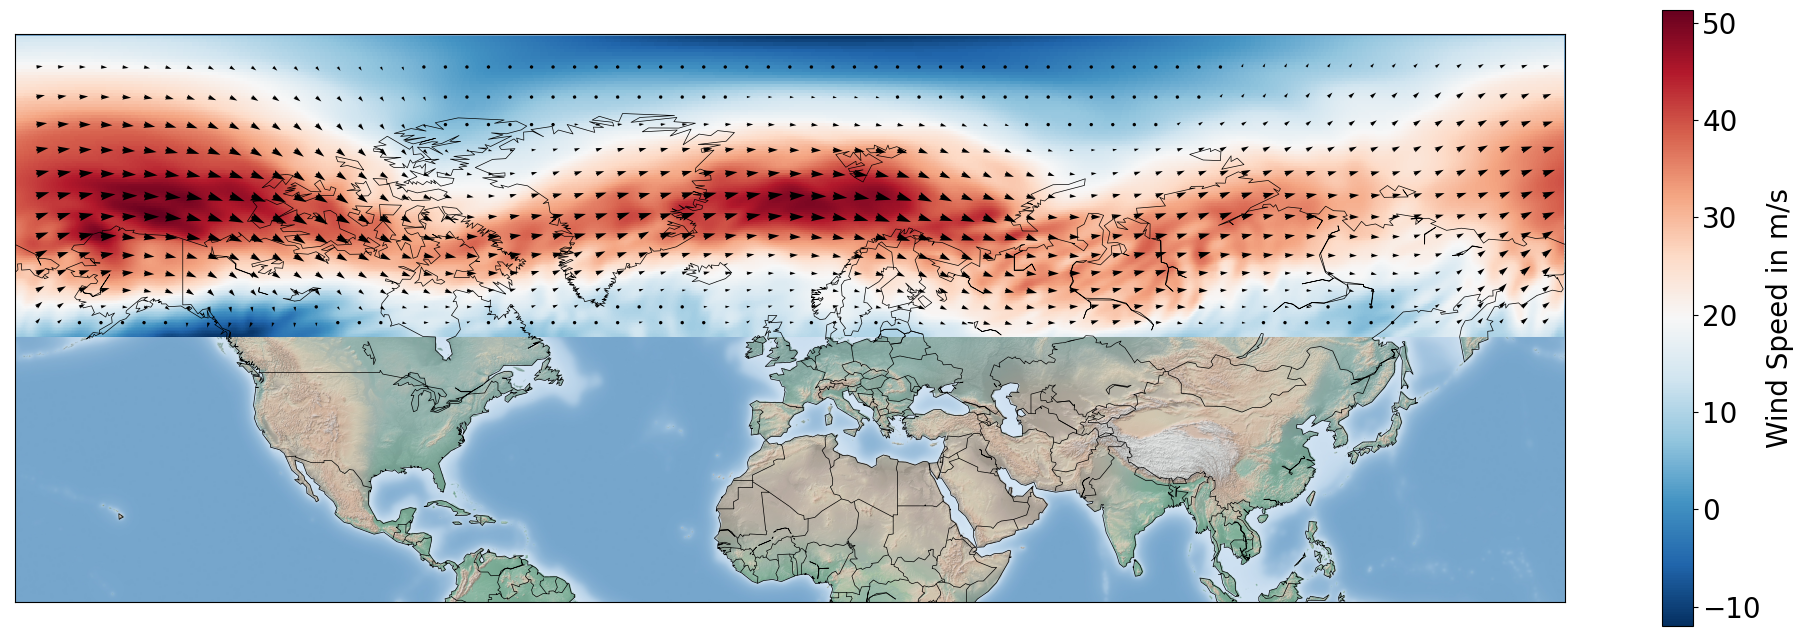

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(25, 8))

# plot miller projection
m = Basemap(projection='mill',
            llcrnrlat = 0,
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon =180)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.grid_[0], 
             grid.grid_[1], 
             data_u,
             latlon=True, cmap='RdBu_r',
             shading='auto')

x = grid.grid_[0][::10, ::20]
y = grid.grid_[1][::10, ::20]

data_u_d = data_u[::10, ::20]
data_v_d = data_v[::10, ::20]

m.quiver(x, y, 
     data_u_d, data_v_d, scale = 5000, latlon=True)

m.drawcoastlines(linewidth=0.5, linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid', color='k')

# Increase the size of the title and colorbar labels
title_fontsize = 30
colorbar_fontsize = 20

# plt.title('Wind Magnitude and Direction on 2009-01-24', fontsize=title_fontsize,y=1.05)
cbar = plt.colorbar(label='Wind Speed in m/s')
cbar.ax.tick_params(labelsize=colorbar_fontsize)  # increase colorbar label size
cbar.set_label('Wind Speed in m/s', fontsize=colorbar_fontsize)  # increase colorbar label size
